<H1>Multivariate prediction of difference in flows</h1>

In [323]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.discriminant_analysis import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import plotly.graph_objects as go
import os
from plotly.subplots import make_subplots

In [324]:
directory_list = [
    os.path.join('..', 'Inputs_outputs_excels', 'wsv_rhine_export_with_outliers_balanced.xlsx'),
    os.path.join('..', 'Inputs_outputs_excels', 'wsv_rhine_export - pseudo_huber_29_4_2024.xlsx'),
    os.path.join('..', 'Inputs_outputs_excels', 'wsv_rhine_export_outliers_pseudo_huber.xlsx'),
    os.path.join('..', 'Inputs_outputs_excels', 'rate_of_change_df.xlsx')
]
df = pd.read_excel(directory_list[3])     #This contains the flow.bc (Mass Balance Correction) values

df = df[1:]
df_input = df

df_input_roc= pd.read_excel(directory_list[3])
df_input_roc= df_input_roc[0:-1]

df_roc=df

df.index = pd.to_datetime(df['Date'],format='%d.%m.%Y %H:%M:%S')

lag_times= 14

<h2>Preprocessing data </h2>

<h2>Create a new timeseries table with lag</h2>

In [325]:
features_for_input=['ANDER/flow.bc',
                 #'MENDE/flow.bc',
                 #'OPLAD/flow.bc',
                 #'NEUBR/flow.bc',
                 #'RUHRW/flow.bc',
                 #'SCHER/flow.bc',
                 ]
features_for_input_extended=features_for_input

In [326]:
def lag_creator(df, i):
    df_lag = df.shift(-1)  # Shift the DataFrame backwards (upwards in index)
    df_lag = df_lag.rename(columns=lambda col: f"{col}_lag{i}")
    new_cols = df_lag.columns[-1]
    return df_lag, new_cols

for i in range(1, lag_times + 1):
    df_lag, new_cols = lag_creator(df_input[features_for_input], i)
    df_input = pd.concat([df_input, df_lag], axis=1)
    features_for_input_extended.append(new_cols)  # Add all new column names to features_for_input



<h3>Input data</h3>

In [327]:
#df_input=df_input[features_for_input].reset_index(drop=True)
df_input=df_input[features_for_input_extended]
df_input=df_input.reset_index(drop=True)
df_roc=df_roc.reset_index(drop=True)

<h3>Adding periodicity for date</h3>

In [328]:
time=df['Date']
df_time=pd.DataFrame({'Date': time})
df_time['Seconds']=df_time.index.map(pd.Timestamp.timestamp)

#df_time['Day sin']= np.sin(df_time['Seconds']*(2*np.pi/86400))
#df_time['Day cos']= np.cos(df_time['Seconds']*(2*np.pi/86400))
df_time['Year sin']= np.sin(df_time['Seconds']*(2*np.pi/86400/365.2425))
df_time['Year cos']= np.cos(df_time['Seconds']*(2*np.pi/86400/365.2425))
df_time=df_time.drop('Date',axis=1)
df_time=df_time.drop('Seconds',axis=1)
df_time=df_time.reset_index(drop=True)

In [329]:
df_input_concatenated=pd.concat([df_time,df_input,df_roc['Rate of change ANDER/flow.bc']],axis=1,ignore_index=True)
df_input_concatenated=df_input_concatenated[0:-lag_times]
X_val = df_input_concatenated   #validation dataset

df_input_concatenated

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,-1.000000,0.000097,2120,2020.0,2000.0,2090.0,2020.0,1870.0,1770.0,1660.0,1550.0,1510.0,1490.0,1440.0,1410.0,1360.0,1330.0,-120.0
1,-0.999850,0.017299,2020,2000.0,2090.0,2020.0,1870.0,1770.0,1660.0,1550.0,1510.0,1490.0,1440.0,1410.0,1360.0,1330.0,1300.0,-100.0
2,-0.999405,0.034495,2000,2090.0,2020.0,1870.0,1770.0,1660.0,1550.0,1510.0,1490.0,1440.0,1410.0,1360.0,1330.0,1300.0,1270.0,-20.0
3,-0.998664,0.051682,2090,2020.0,1870.0,1770.0,1660.0,1550.0,1510.0,1490.0,1440.0,1410.0,1360.0,1330.0,1300.0,1270.0,1240.0,90.0
4,-0.997627,0.068853,2020,1870.0,1770.0,1660.0,1550.0,1510.0,1490.0,1440.0,1410.0,1360.0,1330.0,1300.0,1270.0,1240.0,1230.0,-70.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3633,-0.944717,-0.327888,1760,1960.0,1950.0,1820.0,1740.0,1700.0,1640.0,1640.0,1610.0,1470.0,1390.0,1290.0,1230.0,1180.0,1160.0,140.0
3634,-0.950217,-0.311589,1960,1950.0,1820.0,1740.0,1700.0,1640.0,1640.0,1610.0,1470.0,1390.0,1290.0,1230.0,1180.0,1160.0,1110.0,200.0
3635,-0.955436,-0.295197,1950,1820.0,1740.0,1700.0,1640.0,1640.0,1610.0,1470.0,1390.0,1290.0,1230.0,1180.0,1160.0,1110.0,1110.0,-10.0
3636,-0.960373,-0.278718,1820,1740.0,1700.0,1640.0,1640.0,1610.0,1470.0,1390.0,1290.0,1230.0,1180.0,1160.0,1110.0,1110.0,1080.0,-130.0


<h3>Creating the label dataframe</h3>

In [330]:
output_attributes=['BONN/flow.obs','BONN/flow.bc'
                    #'KOELN/flow.obs',
                    #'DUESS/flow.obs',
                    #'DUISB/flow.obs',
                    #'WESEL/flow.obs',
                    #'REES/flow.obs',
                    #'EMMER/flow.obs'
                    ]
df_output=df[output_attributes]
df_output=df_output[0:-lag_times]
y_val=df_output


<h2>Splitting data into test, validation and train with window size</h2>

In [331]:
X_train, X_test, y_train, y_test = train_test_split(df_input_concatenated, df_output, test_size=0.33, random_state=42)


<h1> Feed forward neural network </h1>

<h2> Define the neural network model</h2>

In [332]:
model = Sequential([
    Dense(100, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(100, activation='relu'),
    Dense(y_train.shape[1])  # Output layer
])

c:\Projects\venv0.7\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



<h2> Compile the model </h2>

In [333]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error',metrics=['mean_absolute_error'])

<h2> Model fit </h2>

In [334]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=200, validation_split=0.3)

Epoch 1/200


54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 3484713.7500 - mean_absolute_error: 1498.8206 - val_loss: 647397.1875 - val_mean_absolute_error: 573.7496
Epoch 2/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 492695.5938 - mean_absolute_error: 443.6089 - val_loss: 194593.8594 - val_mean_absolute_error: 228.0118
Epoch 3/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 182189.9219 - mean_absolute_error: 233.8257 - val_loss: 144307.2031 - val_mean_absolute_error: 193.4160
Epoch 4/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 129709.4531 - mean_absolute_error: 186.4310 - val_loss: 111729.1562 - val_mean_absolute_error: 170.3134
Epoch 5/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 103644.8203 - mean_absolute_error: 170.1826 - val_loss: 86165.3984 - val_mean_absolute_error: 145.4731
Epoch 6/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 70442.1953 - mean_absolute_error: 142.2350 - val_loss: 65657.7500 - val_mean_absolute_error: 124.2583
Epoch 7/200
54/54 ━━━━━━━━━━━━━━━━

<h2>Model evaluation </h2>

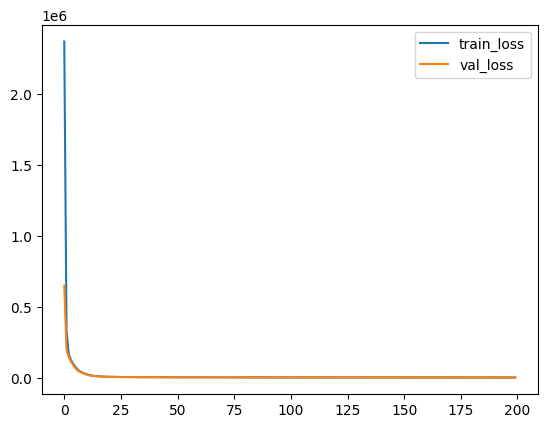

In [335]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [336]:
predictions = model.predict(X_test)

mae_FFNN=mean_absolute_error(y_test, predictions)
mse_FFNN=mean_squared_error(y_test, predictions)

predictions_FFNN_df=pd.DataFrame(predictions)
predictions_FFNN_df.columns=y_test.columns

op=pd.DataFrame(predictions)
mae_FFNN, mse_FFNN

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


(24.8294320157322, 1335.916881635101)

<h2>Plotting the validation loss and training loss</h2>

<h2>Validation </h2>

In [337]:
predictions_val = model.predict(X_val)

mae_FFNN_val=mean_absolute_error(y_val, predictions_val)
mse_FFNN_val=mean_squared_error(y_val, predictions_val)

predictions_FFNN_df_val=pd.DataFrame(predictions_val)
predictions_FFNN_df_val.columns=y_val.columns

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


<h2>Evaluation metrics for each and every label</h2>

In [338]:
mae_dict_FFNN_val = {}
mse_dict_FFNN_val = {}
for column in predictions_FFNN_df_val.columns:
    mae_val = mean_absolute_error(y_val[column], predictions_FFNN_df_val[column])
    mse_val = mean_squared_error(y_val[column], predictions_FFNN_df_val[column])
    mae_dict_FFNN_val[column] = mae_val
    mse_dict_FFNN_val[column] = mse_val

print("MAE for each column:")
for column, mae_val in mae_dict_FFNN_val.items():
    print(f"{column}: {mae_val}")

print("\nMSE for each column:")
for column, mse_val in mse_dict_FFNN_val.items():
    print(f"{column}: {mse_val}")


MAE for each column:
BONN/flow.obs: 29.674723083596756
BONN/flow.bc: 16.407384394617356

MSE for each column:
BONN/flow.obs: 1747.828809064193
BONN/flow.bc: 512.2930344542058


<h1>Linear Regression</h1>

In [339]:
regressor= LinearRegression()
model_linear= regressor.fit(X_val.iloc[:,[-1]],y_val.iloc[:,[1]])
prediction_linear= regressor.predict(X_val.iloc[:,[-1]]).reshape(-1)

mae_val_lin = mean_absolute_error(y_val.iloc[:,[1]], prediction_linear)
mse_val_lin = mean_squared_error(y_val.iloc[:,[1]], prediction_linear)
mae_val_lin, mse_val_lin


(16.228330514306535, 502.7452449109349)

<h2>Output visualization</h2>

In [344]:
i = 0
data = {
    'Date': y_val.index,
    'Discharge MIMO FFNN': predictions_val[:, i],
    'Flow observed': np.array(y_val)[:, i],
    'MBC MIMO FFNN': predictions_val[:, i+1],
    'MBC Lin Reg': prediction_linear,
    'MBC DA': np.array(y_val)[:, i+1],
}

df_plot_val = pd.DataFrame(data)
df_plot_val['Random error FFNN'] = df_plot_val['MBC DA'] - df_plot_val['MBC MIMO FFNN']
df_plot_val['Random error LR'] = df_plot_val['MBC DA'] - df_plot_val['MBC Lin Reg']

# Create subplots
fig = make_subplots(
    rows=3, cols=1,
    shared_xaxes=True,
    subplot_titles=(
        'Discharge prediction using FFNN ' + df_output.columns[i],
        'MBC prediction ' + df_output.columns[i],
        'Random error ' + df_output.columns[i]
    ),
    vertical_spacing=0.05
)

# Add traces for the first subplot
fig.append_trace(
    go.Scatter(x=df_plot_val['Date'], 
               y=df_plot_val['Discharge MIMO FFNN'],
               mode='lines',
               name='Discharge MIMO FFNN',
               legendgroup='1',
               marker={'color': 'red'}),
    row=1, col=1
)
fig.append_trace(
    go.Scatter(x=df_plot_val['Date'],
               y=df_plot_val['Flow observed'],
               mode='lines',
               name='Flow observed',
               legendgroup='1',
               marker={'color': 'green'}),
    row=1, col=1
)

# Add traces for the second subplot
fig.append_trace(
    go.Scatter(x=df_plot_val['Date'],
               y=df_plot_val['MBC MIMO FFNN'],
               mode='lines',
               name='MBC MIMO FFNN',
               legendgroup='2',
               marker={'color': 'red'}),
    row=2, col=1
)
fig.append_trace(
    go.Scatter(x=df_plot_val['Date'],
               y=df_plot_val['MBC DA'],
               mode='lines',
               name='MBC DA',
               legendgroup='2',
               marker={'color': 'blue'}),
    row=2, col=1
)
fig.append_trace(
    go.Scatter(x=df_plot_val['Date'],
               y=df_plot_val['MBC Lin Reg'],
               mode='lines',
               name='MBC Lin Reg',
               legendgroup='2',
               marker={'color': 'goldenrod'}),
    row=2, col=1
)

# Add traces for the third subplot
fig.append_trace(
    go.Scatter(x=df_plot_val['Date'],
               y=df_plot_val['Random error FFNN'],
               mode='lines',
               name='Random error FFNN',
               legendgroup='3',
               marker={'color': 'red'}),
    row=3, col=1
)
fig.append_trace(
    go.Scatter(x=df_plot_val['Date'],
               y=df_plot_val['MBC DA'],
               mode='lines',
               name='MBC DA',
               legendgroup='3',
               marker={'color': 'blue'}),
    row=3, col=1
)
fig.append_trace(
    go.Scatter(x=df_plot_val['Date'],
               y=df_plot_val['Random error LR'],
               mode='lines',
               name='Random error LR',
               legendgroup='3',
               marker={'color': 'goldenrod'}),
    row=3, col=1
)

# Update layout
fig.update_layout(
    height=1100, width=900,
    template='simple_white',
    xaxis=dict(showline=True, linewidth=1, linecolor='black', mirror=True),
    yaxis=dict(showline=True, linewidth=1, linecolor='black', mirror=True),
    xaxis2=dict(showline=True, linewidth=1, linecolor='black', mirror=True),
    yaxis2=dict(showline=True, linewidth=1, linecolor='black', mirror=True),
    xaxis3=dict(showline=True, linewidth=1, linecolor='black', mirror=True),
    yaxis3=dict(showline=True, linewidth=1, linecolor='black', mirror=True),
    legend_tracegroupgap = 270,
    legend={
        'x': 0.75, # x position
        'y': 0.99, # y position
        'bgcolor': 'rgba(0, 0, 0, 0)'
    }
)

fig.update_xaxes(title_text="Date", row=3, col=1)  # Example for updating x-axis label of the third subplot
fig.update_yaxes(title_text="Discharge (m³/s)", row=1, col=1)
fig.update_yaxes(title_text="MBC (m³/s)", row=2, col=1)
fig.update_yaxes(title_text="Discharge (m³/s)", row=3, col=1)

fig.show()

In [341]:
i=0
data= {
    'Date': y_val.index,
    'Discharge MIMO FFNN': predictions_rescaled_val[:, i],
    'Flow observed': np.array(y_val)[:, i],
    'MBC MIMO FFNN' : predictions_rescaled_val[:, i+1],
    'MBC Lin Reg': prediction_linear,
    'MBC DA': np.array(y_val)[:, i+1],
    }

df_plot_val = pd.DataFrame(data)

df_plot_val['Random error FFNN']= df_plot_val['MBC DA']-df_plot_val['MBC MIMO FFNN']

fig1 = px.scatter(df_plot_val,
                  x='Date',
                  y=['Discharge MIMO FFNN', 'Flow observed'],
                  labels={'value': 'Discharge (m³/s)'},
                  title='Discharge prediction using FFNN ' + df_output.columns[i],
                  color_discrete_sequence=['blue', 'orange'])
fig1.update_traces(marker={'size': 2}, mode='lines+markers')
fig1.update_layout(
    height=500, width=900,
    legend={
        'x': 0.75, # x position
        'y': 0.99, # y position
        'bgcolor': 'rgba(255, 255, 255, 0.5)', # semi-transparent background
        'bordercolor': 'Black',
        'borderwidth': 1
        }
)
fig1.show()

fig2 = px.scatter(df_plot_val,
                  x='Date',
                  y=['MBC MIMO FFNN', 'MBC DA','MBC Lin Reg'],
                  labels={'value': 'Mass balance correction (m³/s)'},
                  title='MBC prediction ' + df_output.columns[i],
                  color_discrete_sequence=['blue', 'orange','green'])
fig2.update_traces(marker={'size': 2}, mode='lines+markers')
fig2.update_layout(
    height=500, width=900,
    legend={
        'x': 0.8, # x position
        'y': 0.99, # y position
        'bgcolor': 'rgba(255, 255, 255, 0.5)', # semi-transparent background
        'bordercolor': 'Black',
        'borderwidth': 1
        }
)
fig2.show()

fig3 = px.scatter(df_plot_val,
                  x='Date',
                  y=['Random error FFNN', 'MBC DA'],
                  labels={'value': 'Discharge (m³/s)'},
                  title='MBC prediction ' + df_output.columns[i],
                  color_discrete_sequence=['blue', 'orange'])
fig3.update_traces(marker={'size': 2}, mode='lines+markers')
fig3.update_layout(
    height=500, width=900,
    legend={
        'x': 0.75, # x position
        'y': 0.99, # y position
        'bgcolor': 'rgba(255, 255, 255, 0.5)', # semi-transparent background
        'bordercolor': 'Black',
        'borderwidth': 1
        }
)
fig3.show()

# filepath=r'C:\Users\sujan.maharjan\Desktop\KISTERS\figures\MV_FFNN_'+df_output.columns[i][:3]+'.html'
# fig.write_html(filepath)

NameError: name 'predictions_rescaled_val' is not defined